In [12]:
import pandas as pd
import folium
from branca.colormap import LinearColormap
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [13]:
# Load the fertilizer schedule
fertilizer_schedule_df = pd.read_csv('Fertilizer_Schedule.csv')
# File paths for the Excel files
uploaded_file = 'dataset1/dataset.xlsx'  # Replace with the actual file path
corners_file = 'dataset1/boundary.xlsx'  # Replace with the actual file path

In [20]:
# Read the uploaded files into DataFrames
df = pd.read_excel(uploaded_file)
corners_df = pd.read_excel(corners_file)

# Display the data in a table
print('Data Table')
print(df)

Data Table
    Latitude  Longitude  Moisture (%)  Temperature (C)  EC (us/cm)   Ph  \
0   6.973684  79.942889          19.5             32.8         219  7.1   
1   6.973782  79.942948          16.9             32.8         218  7.9   
2   6.973881  79.943008          17.9             32.7         214  7.4   
3   6.973541  79.943025          16.4             32.6         220  7.4   
4   6.973640  79.943084          12.7             32.6          95  7.6   
5   6.973739  79.943144           9.5             33.0         101  7.3   
6   6.973838  79.943203           9.1             32.9         195  7.7   
7   6.973937  79.943262           3.1             32.8         117  6.3   
8   6.973597  79.943280           6.4             32.0         106  8.3   
9   6.973695  79.943339          19.5             32.8         219  7.1   
10  6.973794  79.943398          16.9             32.8         218  7.9   
11  6.973893  79.943458          17.9             32.7         214  7.4   
12  6.973992  

In [21]:
# Provide detailed insights on the soil data
print('Soil Data Insights')
summary_df = pd.DataFrame({
    'Mean': df.mean(),
    'Max': df.max(),
    'Min': df.min(),
    'Std Dev': df.std(),
    'Count': df.count()
})
print(summary_df)

Soil Data Insights
                          Mean         Max        Min    Std Dev  Count
Latitude              6.973861    6.974201   6.973541   0.000178     25
Longitude            79.943483   79.944086  79.942889   0.000357     25
Moisture (%)         13.000000   19.500000   3.100000   5.183628     25
Temperature (C)      32.712000   33.000000  32.000000   0.250533     25
EC (us/cm)          169.280000  220.000000  95.000000  55.622627     25
Ph                    7.456000    8.300000   6.300000   0.474412     25
Nitrogen (mg/kg)     12.880000   23.000000   5.000000   5.918333     25
Posphorous (mg/kg)  108.880000  145.000000  25.000000  33.802515     25
Potassium (mg/kg)   110.320000  130.000000  91.000000  11.126994     25


In [15]:
# Extract coordinates
coordinates = [tuple(map(float, corner.split(','))) for corner in corners_df['Corners']]

# Ensure the first and last points are the same to form a closed boundary
if coordinates[0] != coordinates[-1]:
    coordinates.append(coordinates[0])

# Calculate the area of the land
polygon = Polygon(coordinates)
area_sq_meters = polygon.area * (111320 ** 2)  # approximate conversion from degrees to meters squared
area_acres = area_sq_meters * 0.000247105  # conversion from square meters to acres

print(f"Area of the land: {area_sq_meters:.2f} square meters")
print(f"Area of the land: {area_acres:.2f} acres")

Area of the land: 6778.46 square meters
Area of the land: 1.67 acres


In [16]:
# Function to map values to colors
def get_color(value, min_val, max_val):
    colormap = LinearColormap(colors=['blue', 'lime', 'red'], vmin=min_val, vmax=max_val)
    return colormap(value)

In [17]:
# Select parameter to visualize on the map
parameter = 'Nitrogen (mg/kg)'  # You can change this to any parameter you want to visualize

min_val = df[parameter].min()
max_val = df[parameter].max()

# Create a Folium map centered around the first point
m = folium.Map(location=[coordinates[0][0], coordinates[0][1]], zoom_start=17)

# Add points to the map with color intensity based on the selected parameter
for _, row in df.iterrows():
    color = get_color(row[parameter], min_val, max_val)
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{parameter}: {row[parameter]}"
    ).add_to(m)

# Add a line to the map to mark the boundary of the land
folium.PolyLine(locations=coordinates, color='blue', weight=2.5, opacity=1).add_to(m)

# Display the map
m.save('map.html')
print("Map saved as 'map.html'")

Map saved as 'map.html'


Nutrient Distribution Profile


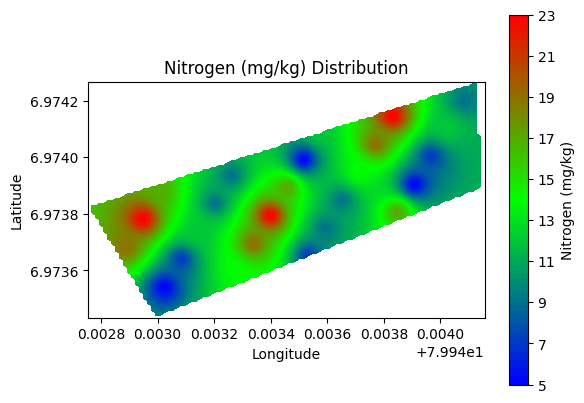

Fertilizer Recommendation


In [18]:
# Interpolation
print('Nutrient Distribution Profile')

# Define grid within the bounding box of the polygon
min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:100j, min_lon:max_lon:100j]

def idw(x, y, z, xi, yi, power=2):
    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 + (y[:, None, None] - yi[None, :, :])**2)
    weights = 1 / (dist**power)
    weights[dist == 0] = np.inf  # Handle zero distance (to avoid division by zero)
    z_idw = np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)
    return z_idw

# Perform IDW interpolation
x = df['Latitude'].values
y = df['Longitude'].values
z = df[parameter].values
grid_z_idw = idw(x, y, z, grid_x, grid_y)

# Mask the grid outside the polygon
mask = np.array([Point(x, y).within(polygon) for x, y in zip(grid_x.flatten(), grid_y.flatten())])
grid_z_idw = np.ma.masked_array(grid_z_idw, ~mask.reshape(grid_z_idw.shape))

# Plot the interpolated data
fig, ax = plt.subplots()
cmap = LinearSegmentedColormap.from_list("mycmap", ['blue', 'lime', 'red'])
contour = ax.contourf(grid_y, grid_x, grid_z_idw, cmap=cmap, levels=100)  # Swap grid_x and grid_y for correct orientation
plt.colorbar(contour, ax=ax, label=parameter)
ax.set_title(f'{parameter} Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', 'box')
plt.show()

# Fertilizer recommendation
print('Fertilizer Recommendation')

# Select crop age group and time period
age_group = 'For 3 Month'  # Change this to the desired age group
time_period = '2 Weeks'  # Change this to the desired time period

In [19]:
# Filter the time periods based on the selected age group
time_period_options = fertilizer_schedule_df[fertilizer_schedule_df['Age Group'] == age_group]['Time *'].unique()

if len(time_period_options) > 0 and time_period in time_period_options:
    # Filter the fertilizer schedule based on the selected age group and time period
    filtered_schedule = fertilizer_schedule_df[
        (fertilizer_schedule_df['Age Group'] == age_group) & (fertilizer_schedule_df['Time *'] == time_period)
    ]

    # Display the recommended fertilizer amounts
    if not filtered_schedule.empty:
        urea_required = filtered_schedule['Urea'].values[0]
        tsp_required = filtered_schedule['T.S.P'].values[0]
        mop_required = filtered_schedule['M.O.P'].values[0]

        print(f"Recommended amounts of fertilizers for {age_group} crops during {time_period}:")
        print(f"Urea: {urea_required} kg/ha")
        print(f"T.S.P: {tsp_required} kg/ha")
        print(f"M.O.P: {mop_required} kg/ha")

        # Calculate the deficit and additional fertilizer needed
        def calculate_fertilizer(soil_nutrient, nutrient_threshold, fertilizer_pct):
            deficit = nutrient_threshold - soil_nutrient
            required_fertilizer = max(deficit / fertilizer_pct, 0)  # Ensure no negative values
            return required_fertilizer

        nitrogen_threshold = urea_required * 0.46  # Assuming Urea is 46% Nitrogen
        phosphorous_threshold = tsp_required * 0.20  # Assuming T.S.P is 20% Phosphorous
        potassium_threshold = mop_required * 0.50  # Assuming M.O.P is 50% Potassium

        soil_nitrogen = df['Nitrogen (mg/kg)'].mean()
        soil_phosphorous = df['Posphorous (mg/kg)'].mean()
        soil_potassium = df['Potassium (mg/kg)'].mean()

        urea_needed = calculate_fertilizer(soil_nitrogen, nitrogen_threshold, 0.46)
        tsp_needed = calculate_fertilizer(soil_phosphorous, phosphorous_threshold, 0.20)
        mop_needed = calculate_fertilizer(soil_potassium, potassium_threshold, 0.50)

        print(f"Additional Urea needed: {urea_needed:.2f} kg/ha")
        print(f"Additional T.S.P needed: {tsp_needed:.2f} kg/ha")
        print(f"Additional M.O.P needed: {mop_needed:.2f} kg/ha")
    else:
        print("No data available for the selected age group and time period.")
else:
    print("No time periods available for the selected age group.")


Recommended amounts of fertilizers for For 3 Month crops during 2 Weeks:
Urea: 50 kg/ha
T.S.P: 0 kg/ha
M.O.P: 0 kg/ha
Additional Urea needed: 22.00 kg/ha
Additional T.S.P needed: 0.00 kg/ha
Additional M.O.P needed: 0.00 kg/ha
